# Install Independences

In [1]:
!pip install visualkeras 
# !pip install tensorflow-addons # experimented with radam, we decided to go with nadam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.8 MB/s eta 0:00:00


In [2]:
# FOR SPLITTING DATASET
# Import os to move, modify and create directory for training set and test set
import os
# Import random to generate randomicaly a number
import random
# Import shutil to move the image 
import shutil

# FOR DATA LOADER 
from tensorflow import keras
from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# FOR AUXILIARY FUNCTION OF NEURAL NETWORK
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import cv2

# FOR MODELS NEURAL NETWORK
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, PReLU
from keras.backend import clear_session, reset_uids
from keras import backend as K
from keras.optimizers import Nadam, Adam, AdamW

# FOR TRAINING 
from keras.utils import plot_model
import visualkeras


2024-02-09 21:42:07.898284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 21:42:07.898394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 21:42:08.027156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus =list_physical_devices('GPU')
for gpu in gpus: 
    set_memory_growth(gpu, True)

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Pre-Processing Data: Splitting 

# DataLoader

In [5]:
def data_load(train_dir, validation_dir, image_size, num_batch):
    # Process Data Augmentation
    datagen=ImageDataGenerator(rescale = 1./255,     # Rescaling factor
                               shear_range=0.2,      # Shear Intensity (Shear angle in counter-clockwise direction in degrees) 
                               zoom_range=0.2,       # Range for random zoom.
                               horizontal_flip=True) # Randomly flip inputs horizontally. 
    
    print('------ Loading TRAIN SET -------')
    training_set=datagen.flow_from_directory(train_dir,
                                         target_size=(image_size[0], image_size[1]),
                                         batch_size=num_batch,
                                         class_mode='categorical',
                                         color_mode='rgb')
    
    print('\n\n------ Loading VALIDATION SET ------')
    validation_set=datagen.flow_from_directory(validation_dir,
                                           target_size=(image_size[0], image_size[1]),
                                           batch_size=num_batch,
                                           class_mode='categorical',
                                           color_mode='rgb')
    return training_set, validation_set

# Auxiliary Functions

## Training

In [6]:
def train_model(model, train_set, val_set, early_stopping, pat, num_model, num_epochs):
    # Apply early stop --> to predict overfitting case
    es = None
    if early_stopping == True:
        es = EarlyStopping(monitor='val_loss',
                           mode='min', 
                           patience=pat,
                           restore_best_weights = True,
                           verbose=1
                           )
        # Create a File Pre trained
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[es, ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                                             patience=5, min_lr=0.001, 
                                                                             mode='min', verbose=1)],
                                      epochs = num_epochs)
        
    else:
        filepath = "model"+str(num_model)+".h5"
        # Checkpoint of file
        ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Fit the model with respect to training and validation generator
        history = model.fit_generator(generator=train_set, 
                                      validation_data= val_set,
                                      callbacks=[ckpt, ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                                                         patience=5, min_lr=0.001, 
                                                                         mode='min', verbose=1)],
                                      epochs = num_epochs)

    return history, filepath, es

In [7]:
def eval_model(model, train_set , val_set):
    # Evaluate the Model
    metrics_train = model.evaluate(train_set)
    metrics_val = model.evaluate(val_set)

    print("Train Accuracy = %.4f - Train Loss = %.4f" % (metrics_train[1], metrics_train[0]))
    print("Test Accuracy = %.4f - Test Loss = %.4f" % (metrics_val[1], metrics_val[0]))
    
    print("Train F1-Score = %.4f" % (metrics_train[2]))
    print("Train Precision = %.4f" % (metrics_train[3]))
    print("Train Recall = %.4f" % (metrics_train[4]))
    
    print("Test F1-Score = %.4f" % (metrics_val[2]))
    print("Test Precision = %.4f" % (metrics_val[3]))
    print("Test Recall = %.4f" % (metrics_val[4]))

## Accuracy and Loss Functions

In [8]:
# Define Loss Functions
def loss_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Accuracy Function
def accuracy_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['acc'], color='teal', label='accuracy')
    plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define F1 Function
def F1_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['f1_m'], color='teal', label='F1_score')
    plt.plot(hist.history['val_f1_m'], color='orange', label='val_F1_score')
    fig.suptitle('F1 Score', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Precision Function
def precision_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['precision_m'], color='teal', label='precision_score')
    plt.plot(hist.history['val_precision_m'], color='orange', label='val_precision_score')
    fig.suptitle('Precision', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

# Define Recall Function
def recall_function(hist):
    fig = plt.figure()
    plt.plot(hist.history['recall_m'], color='teal', label='recall_score')
    plt.plot(hist.history['val_recall_m'], color='orange', label='val_recall_score')
    fig.suptitle('Recall', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()


def plot_history(hist):
    loss_function(hist)
    accuracy_function(hist)
    F1_function(hist)
    precision_function(hist)
    recall_function(hist)

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Models

## Model 1 - ReLU

Image with 64 x 64 x 3 

In [10]:
#%% ----- MODEL 1 -----
#defining model
def model_1a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier


In [11]:
#%% ----- MODEL 1 -----
#defining model
def model_1b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

In [12]:
#%% ----- MODEL 1 -----
#defining model
def model_1c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc',f1_m, precision_m, recall_m])
    return classifier

## Model 2 - PReLU

In [13]:
#%% ----- MODEL 2 -----
#Defining model
def model_2a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [14]:
#%% ----- MODEL 2 -----
#Defining model
def model_2b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = AdamW(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [15]:
#%% ----- MODEL 2 -----
#Defining model
def model_2c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same'))
    classifier.add(PReLU())
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer = Nadam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

## Model 3 - GeLU

In [16]:
#%% ----- MODEL 3 -----
#defining model
def model_3a(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Adam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [17]:
#%% ----- MODEL 3 -----
#defining model
def model_3b(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=AdamW(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

In [18]:
#%% ----- MODEL 3 -----
#defining model
def model_3c(image_size, num_classes):
    # Reset sezione
    clear_session()
    reset_uids()

    classifier = Sequential()
    classifier.add(Conv2D(64, (5, 5), input_shape=image_size, padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Conv2D(128, (3, 3), padding='same', activation='gelu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(num_classes, activation = 'softmax'))
    classifier.compile(optimizer=Nadam(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])
    return classifier

# Training

## Paths

In [19]:
train_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/train'
test_dir = '/kaggle/input/pictures-for-train-and-valid/datasetNN/validation'

## Training Model 1

In [20]:
img_size1 = (64, 64, 3)
batch_siz1 = 32
num_classes = 151

In [21]:
neuralnetwork_cnn1a = model_1a(img_size1, num_classes= 151)
neuralnetwork_cnn1a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [22]:
neuralnetwork_cnn1b = model_1b(img_size1, num_classes= 151)
neuralnetwork_cnn1b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

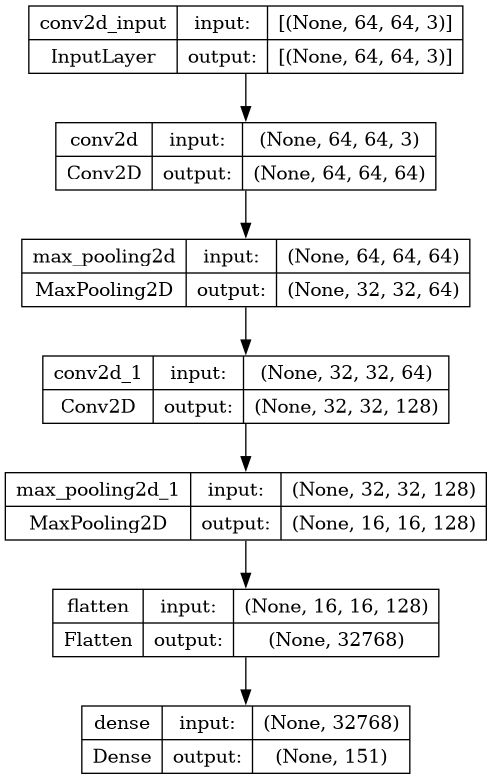

In [23]:
neuralnetwork_cnn1c = model_1c(img_size1, num_classes= 151)
neuralnetwork_cnn1c.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')

#models are all the same, plotting once
plot_model(neuralnetwork_cnn1c, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

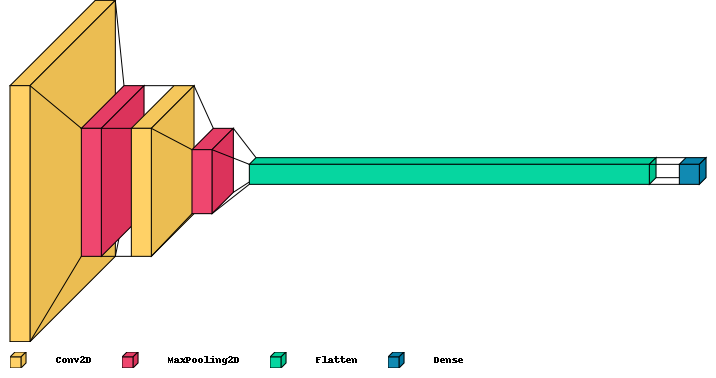

In [24]:
visualkeras.layered_view(neuralnetwork_cnn1c, legend = True, spacing = 30)

In [25]:
train_set1 , val_set1 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size1,
                                  num_batch= batch_siz1)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [26]:
hist1a , fil1a, es1a = train_model(model=neuralnetwork_cnn1a, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=11, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35


I0000 00:00:1707514948.273212      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 [==============================] - ETA: 0s - loss: 4.8504 - acc: 0.0613 - f1_m: 0.0147 - precision_m: 0.1401 - recall_m: 0.0078
Epoch 1: loss improved from inf to 4.85045, saving model to model11.h5
219/219 [==============================] - 74s 320ms/step - loss: 4.8504 - acc: 0.0613 - f1_m: 0.0147 - precision_m: 0.1401 - recall_m: 0.0078 - val_loss: 3.7387 - val_acc: 0.1997 - val_f1_m: 0.0722 - val_precision_m: 0.5928 - val_recall_m: 0.0391 - lr: 0.0015
Epoch 2/35


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 3.5168 - acc: 0.2439 - f1_m: 0.1598 - precision_m: 0.5230 - recall_m: 0.0981
Epoch 2: loss improved from 4.85045 to 3.51684, saving model to model11.h5
219/219 [==============================] - 47s 213ms/step - loss: 3.5168 - acc: 0.2439 - f1_m: 0.1598 - precision_m: 0.5230 - recall_m: 0.0981 - val_loss: 2.7564 - val_acc: 0.3819 - val_f1_m: 0.3280 - val_precision_m: 0.6383 - val_recall_m: 0.2241 - lr: 0.0015
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 3.0950 - acc: 0.3780 - f1_m: 0.3580 - precision_m: 0.5735 - recall_m: 0.2644
Epoch 3: loss improved from 3.51684 to 3.09502, saving model to model11.h5
219/219 [==============================] - 46s 210ms/step - loss: 3.0950 - acc: 0.3780 - f1_m: 0.3580 - precision_m: 0.5735 - recall_m: 0.2644 - val_loss: 2.5780 - val_acc: 0.4988 - val_f1_m: 0.4998 - val_precision_m: 0.6593 - val_recall_m: 0.4058 - lr: 0.0015
Epoch 4/35
219/219 [=========================

In [27]:
hist1b , fil1b, es1b = train_model(model=neuralnetwork_cnn1b, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=12, 
                                num_epochs= 35) # meglio che arrivi a 30

Epoch 1/35


/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.5843 - acc: 0.0749 - f1_m: 0.0247 - precision_m: 0.1913 - recall_m: 0.0136
Epoch 1: loss improved from inf to 4.58427, saving model to model12.h5
219/219 [==============================] - 48s 214ms/step - loss: 4.5843 - acc: 0.0749 - f1_m: 0.0247 - precision_m: 0.1913 - recall_m: 0.0136 - val_loss: 3.7049 - val_acc: 0.2309 - val_f1_m: 0.1485 - val_precision_m: 0.5642 - val_recall_m: 0.0876 - lr: 0.0015
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 3.6643 - acc: 0.2610 - f1_m: 0.1916 - precision_m: 0.4872 - recall_m: 0.1238
Epoch 2: loss improved from 4.58427 to 3.66432, saving model to model12.h5
219/219 [==============================] - 47s 213ms/step - loss: 3.6643 - acc: 0.2610 - f1_m: 0.1916 - precision_m: 0.4872 - recall_m: 0.1238 - val_loss: 3.0285 - val_acc: 0.3752 - val_f1_m: 0.3312 - val_precision_m: 0.6017 - val_recall_m: 0.2315 - lr: 0.0015
Epoch 3/35
219/219 [=============================

In [28]:
hist1c , fil1c, es1c = train_model(model=neuralnetwork_cnn1c, 
                                train_set= train_set1, 
                                val_set= val_set1, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=13, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 4.0120 - acc: 0.1601 - f1_m: 0.0786 - precision_m: 0.3527 - recall_m: 0.0462
Epoch 1: loss improved from inf to 4.01203, saving model to model13.h5
219/219 [==============================] - 50s 220ms/step - loss: 4.0120 - acc: 0.1601 - f1_m: 0.0786 - precision_m: 0.3527 - recall_m: 0.0462 - val_loss: 2.9753 - val_acc: 0.3436 - val_f1_m: 0.2918 - val_precision_m: 0.6008 - val_recall_m: 0.1953 - lr: 0.0015
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 3.0483 - acc: 0.3653 - f1_m: 0.3452 - precision_m: 0.5670 - recall_m: 0.2527
Epoch 2: loss improved from 4.01203 to 3.04833, saving model to model13.h5
219/219 [==============================] - 47s 216ms/step - loss: 3.0483 - acc: 0.3653 - f1_m: 0.3452 - precision_m: 0.5670 - recall_m: 0.2527 - val_loss: 2.5511 - val_acc: 0.4547 - val_f1_m: 0.4518 - val_precision_m: 0.6276 - val_recall_m: 0.3561 - lr: 0.0015
Epoch 3/35
219/219 [==================

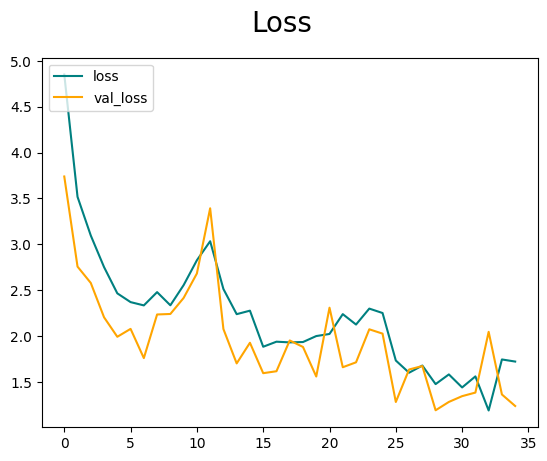

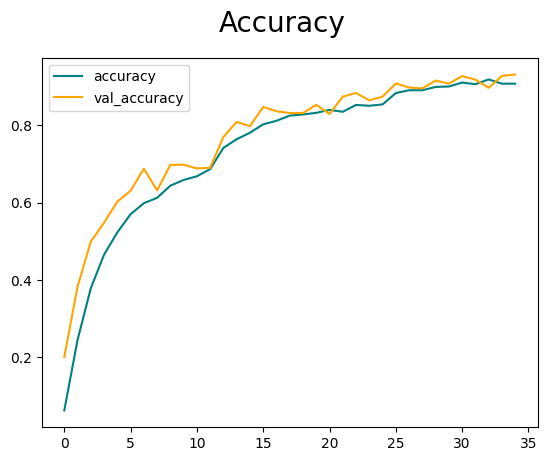

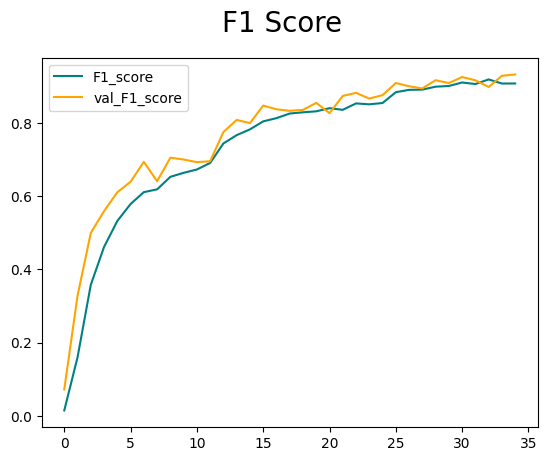

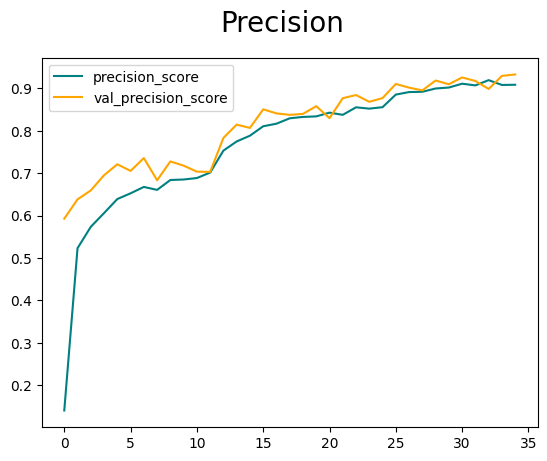

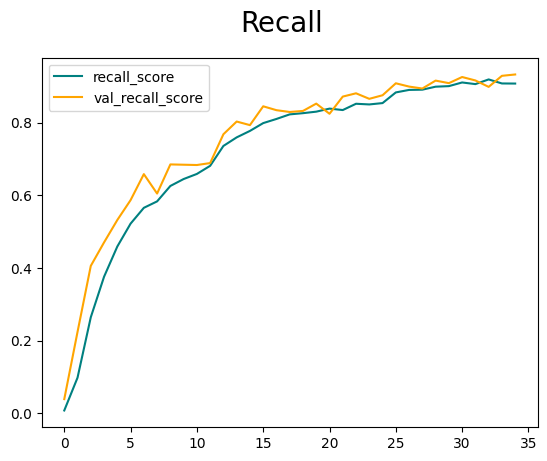

In [29]:
plot_history(hist=hist1a)

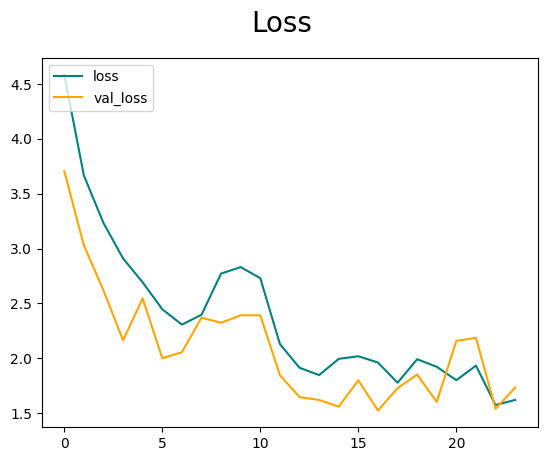

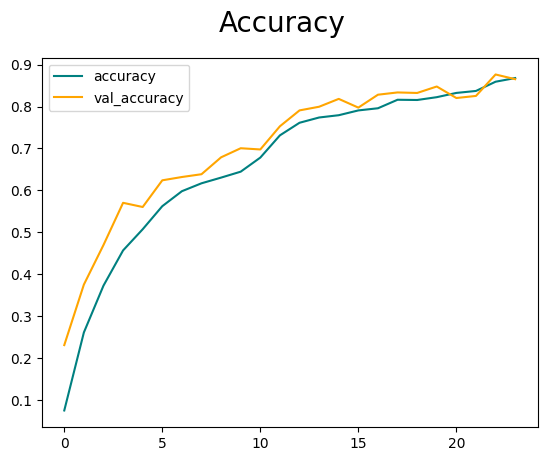

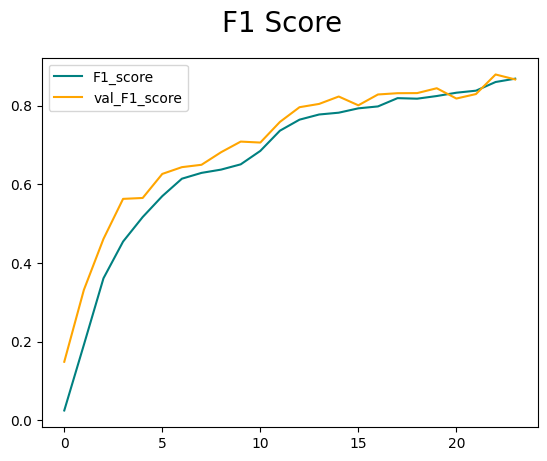

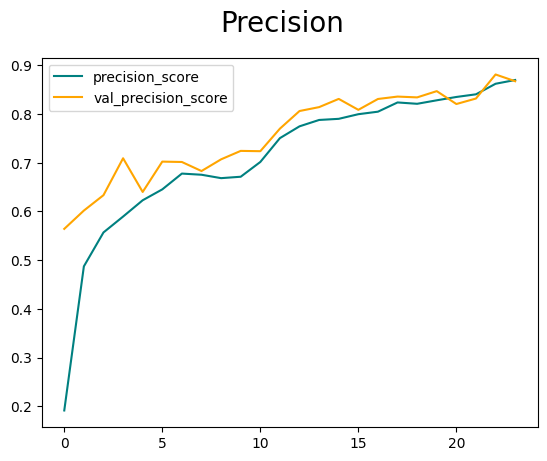

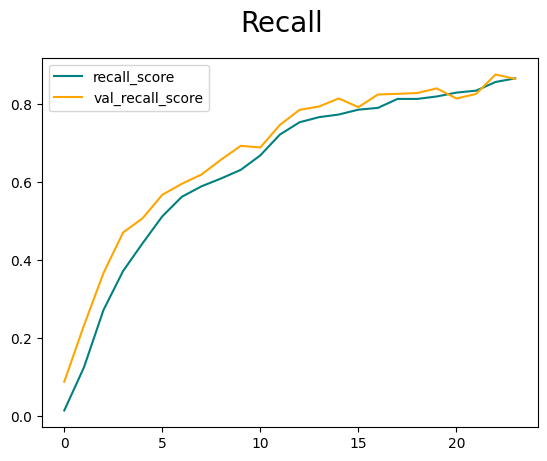

In [30]:
plot_history(hist=hist1b)

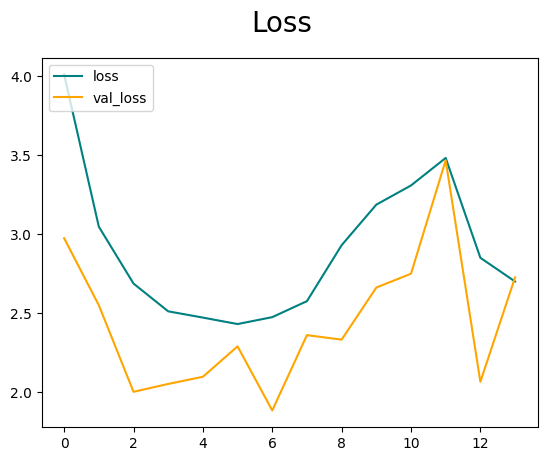

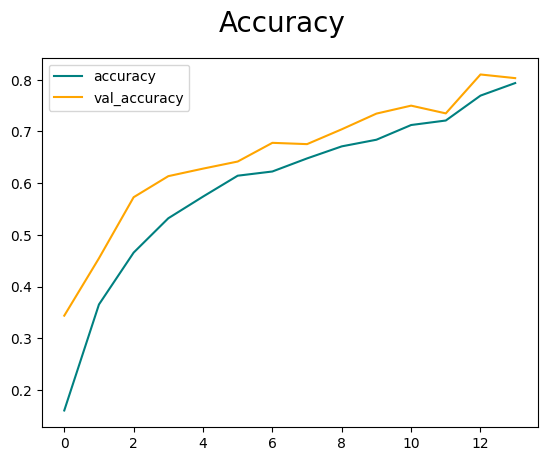

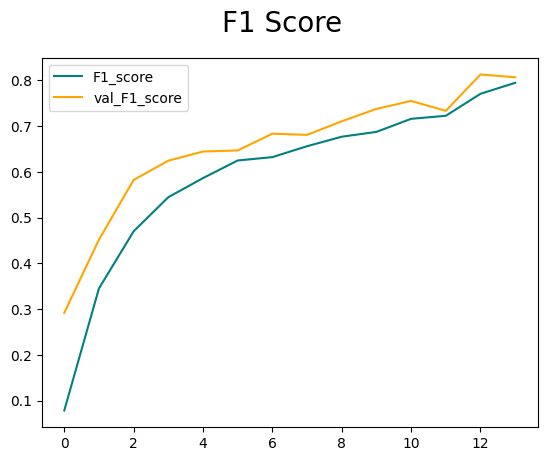

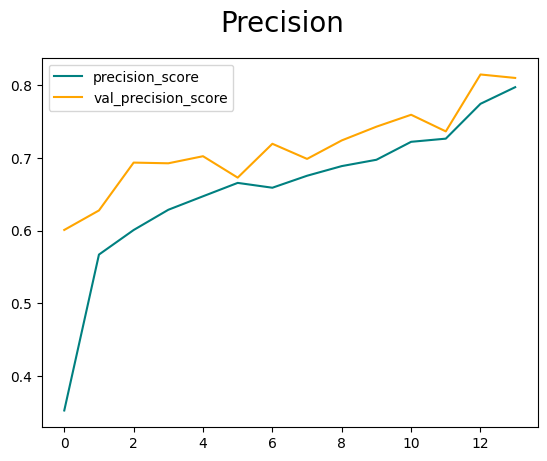

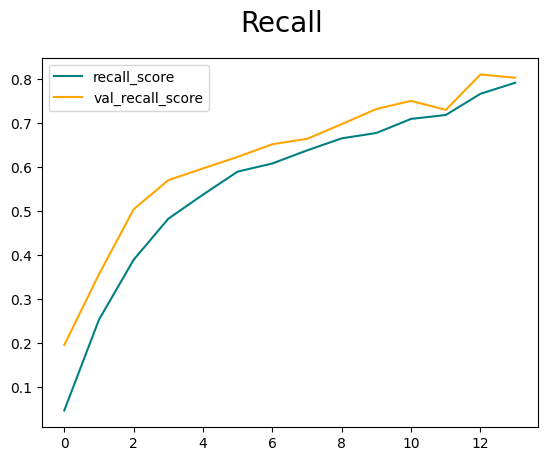

In [31]:
plot_history(hist=hist1c)

## Training Model 2

In [32]:
img_size2 = (64, 64, 3)
batch_siz2 = 32
num_classes = 151

In [33]:
train_set2 , val_set2 = data_load(train_dir = train_dir,
                                validation_dir = test_dir, 
                                image_size=img_size2,
                                num_batch= batch_siz2)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

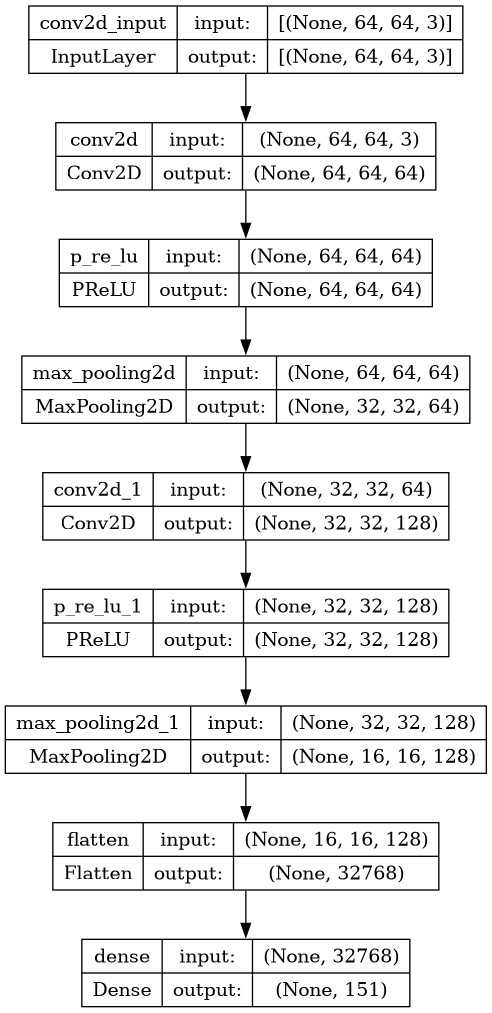

In [34]:
neuralnetwork_cnn2a = model_2a(img_size2, num_classes= 151)
neuralnetwork_cnn2a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn2a, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [35]:
neuralnetwork_cnn2b = model_2b(img_size2, num_classes= 151)
neuralnetwork_cnn2b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [36]:
neuralnetwork_cnn2c = model_2c(img_size2, num_classes= 151)
neuralnetwork_cnn2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 p_re_lu (PReLU)             (None, 64, 64, 64)        262144    
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 p_re_lu_1 (PReLU)           (None, 32, 32, 128)       131072    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [37]:
hist2a , fil2a, es2a = train_model(model=neuralnetwork_cnn2a, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=21, 
                                num_epochs=35)

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 4.4639 - acc: 0.0679 - f1_m: 0.0073 - precision_m: 0.0995 - recall_m: 0.0039
Epoch 1: loss improved from inf to 4.46387, saving model to model21.h5
219/219 [==============================] - 53s 231ms/step - loss: 4.4639 - acc: 0.0679 - f1_m: 0.0073 - precision_m: 0.0995 - recall_m: 0.0039 - val_loss: 3.7217 - val_acc: 0.1809 - val_f1_m: 0.0394 - val_precision_m: 0.4079 - val_recall_m: 0.0210 - lr: 0.0020
Epoch 2/35


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 3.2014 - acc: 0.2560 - f1_m: 0.1346 - precision_m: 0.6576 - recall_m: 0.0774
Epoch 2: loss improved from 4.46387 to 3.20139, saving model to model21.h5
219/219 [==============================] - 48s 217ms/step - loss: 3.2014 - acc: 0.2560 - f1_m: 0.1346 - precision_m: 0.6576 - recall_m: 0.0774 - val_loss: 2.6491 - val_acc: 0.3448 - val_f1_m: 0.2264 - val_precision_m: 0.7796 - val_recall_m: 0.1357 - lr: 0.0020
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 2.4558 - acc: 0.3981 - f1_m: 0.3152 - precision_m: 0.7111 - recall_m: 0.2067
Epoch 3: loss improved from 3.20139 to 2.45583, saving model to model21.h5
219/219 [==============================] - 47s 216ms/step - loss: 2.4558 - acc: 0.3981 - f1_m: 0.3152 - precision_m: 0.7111 - recall_m: 0.2067 - val_loss: 1.9329 - val_acc: 0.5104 - val_f1_m: 0.4227 - val_precision_m: 0.8507 - val_recall_m: 0.2866 - lr: 0.0020
Epoch 4/35
219/219 [=========================

In [38]:
hist2b , fil2b, es2b = train_model(model=neuralnetwork_cnn2b, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=22, 
                                num_epochs=35)

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 4.5415 - acc: 0.0608 - f1_m: 0.0141 - precision_m: 0.1530 - recall_m: 0.0075
Epoch 1: loss improved from inf to 4.54150, saving model to model22.h5
219/219 [==============================] - 49s 217ms/step - loss: 4.5415 - acc: 0.0608 - f1_m: 0.0141 - precision_m: 0.1530 - recall_m: 0.0075 - val_loss: 3.3591 - val_acc: 0.2142 - val_f1_m: 0.0662 - val_precision_m: 0.5796 - val_recall_m: 0.0358 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.9480 - acc: 0.2962 - f1_m: 0.1755 - precision_m: 0.6997 - recall_m: 0.1036
Epoch 2: loss improved from 4.54150 to 2.94798, saving model to model22.h5
219/219 [==============================] - 46s 210ms/step - loss: 2.9480 - acc: 0.2962 - f1_m: 0.1755 - precision_m: 0.6997 - recall_m: 0.1036 - val_loss: 2.4882 - val_acc: 0.3985 - val_f1_m: 0.3193 - val_precision_m: 0.7734 - val_recall_m: 0.2048 - lr: 0.0020
Epoch 3/35
219/219 [==================

In [39]:
hist2c , fil2c, es2c = train_model(model=neuralnetwork_cnn2c, 
                                train_set= train_set2, 
                                val_set= val_set2, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=23, 
                                num_epochs=35)

Epoch 1/35


/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


219/219 [==============================] - ETA: 0s - loss: 4.1804 - acc: 0.1069 - f1_m: 0.0246 - precision_m: 0.2158 - recall_m: 0.0133
Epoch 1: loss improved from inf to 4.18044, saving model to model23.h5
219/219 [==============================] - 49s 211ms/step - loss: 4.1804 - acc: 0.1069 - f1_m: 0.0246 - precision_m: 0.2158 - recall_m: 0.0133 - val_loss: 3.0609 - val_acc: 0.2729 - val_f1_m: 0.1012 - val_precision_m: 0.7023 - val_recall_m: 0.0555 - lr: 0.0020
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.6778 - acc: 0.3598 - f1_m: 0.2461 - precision_m: 0.7245 - recall_m: 0.1522
Epoch 2: loss improved from 4.18044 to 2.67777, saving model to model23.h5
219/219 [==============================] - 46s 210ms/step - loss: 2.6778 - acc: 0.3598 - f1_m: 0.2461 - precision_m: 0.7245 - recall_m: 0.1522 - val_loss: 2.0882 - val_acc: 0.5008 - val_f1_m: 0.3980 - val_precision_m: 0.8549 - val_recall_m: 0.2640 - lr: 0.0020
Epoch 3/35
219/219 [=============================

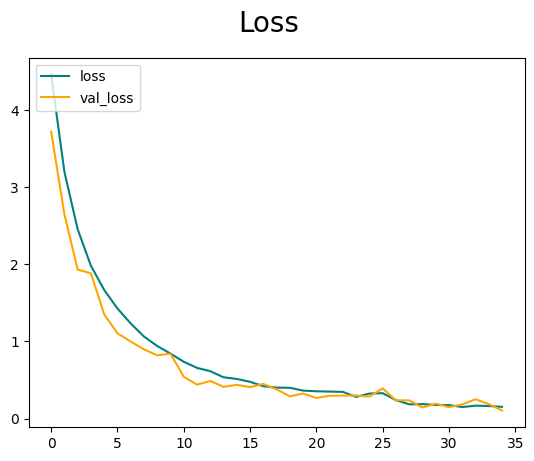

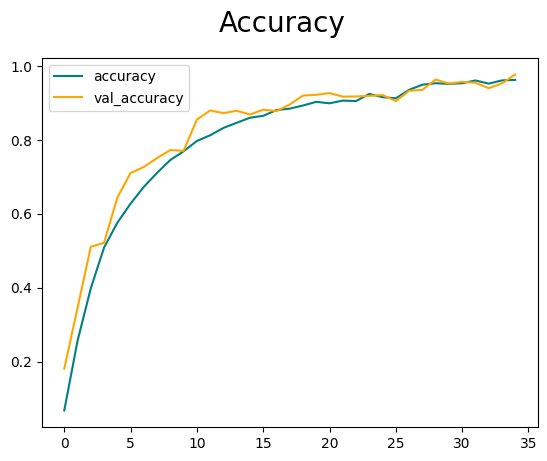

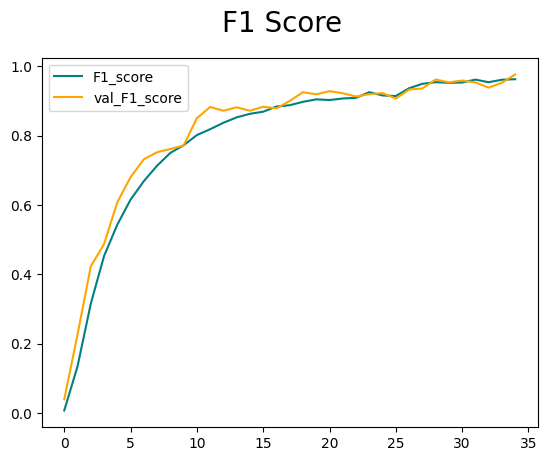

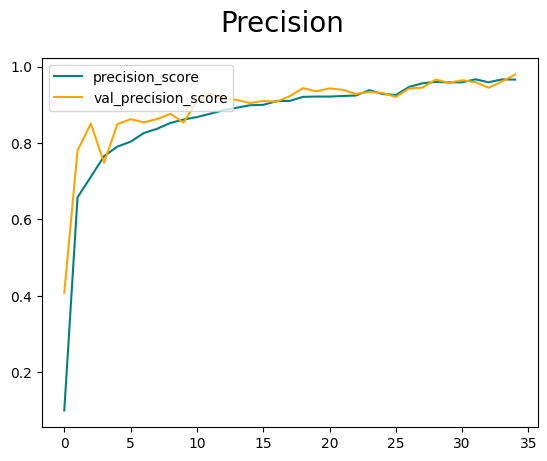

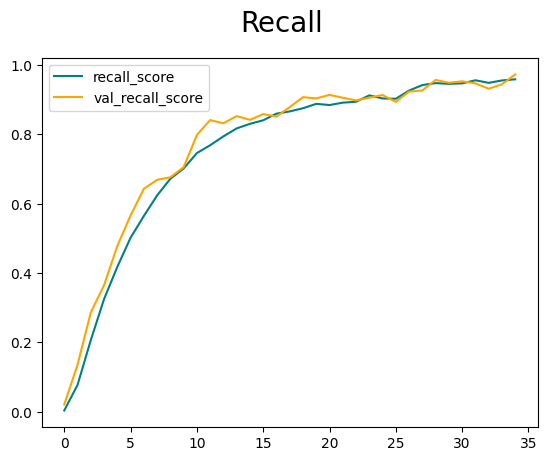

In [40]:
plot_history(hist=hist2a)

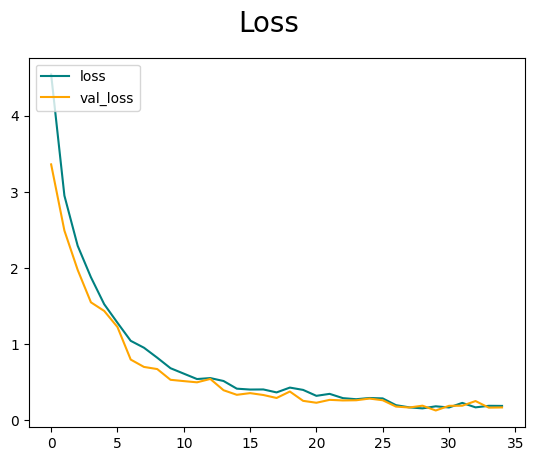

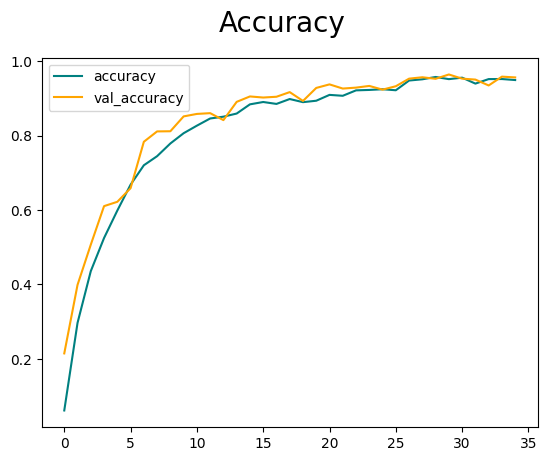

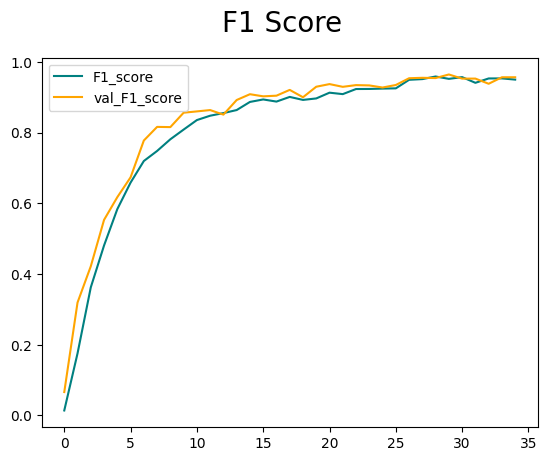

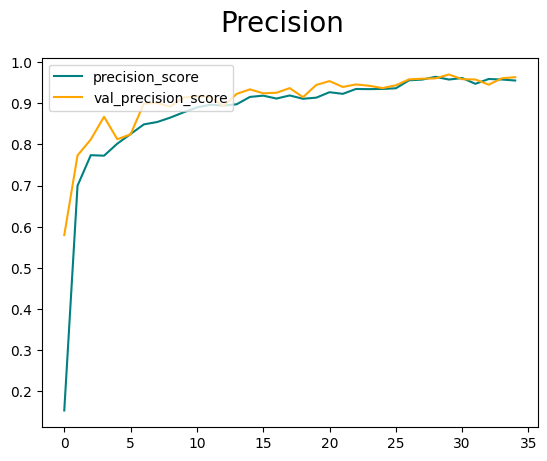

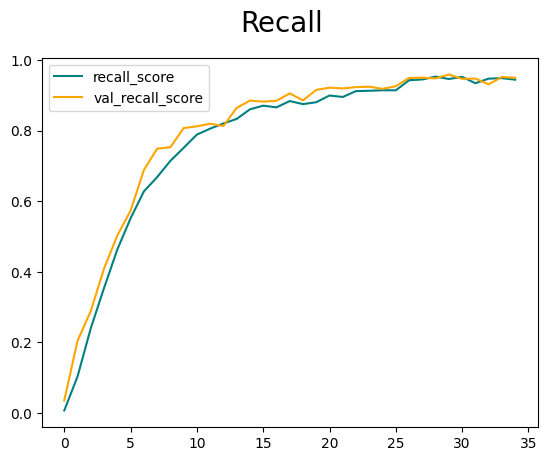

In [41]:
plot_history(hist=hist2b)

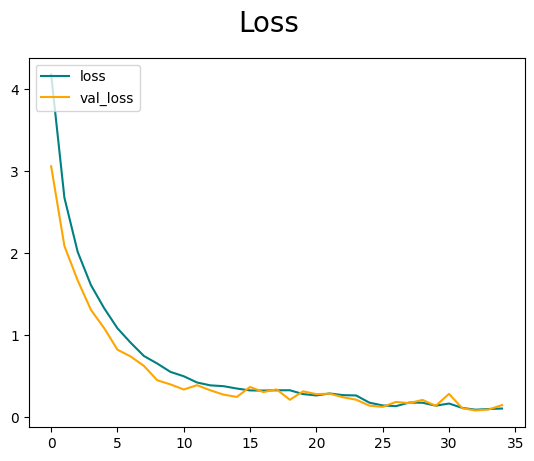

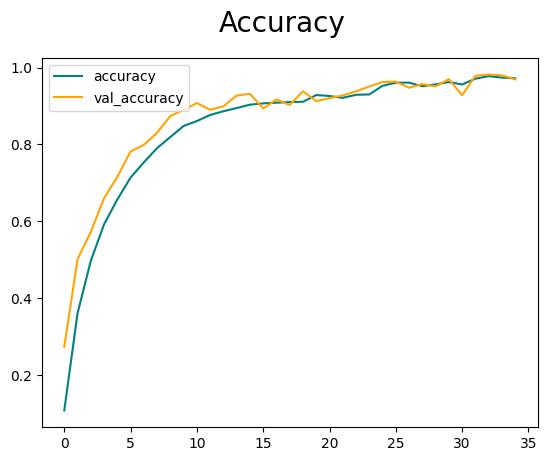

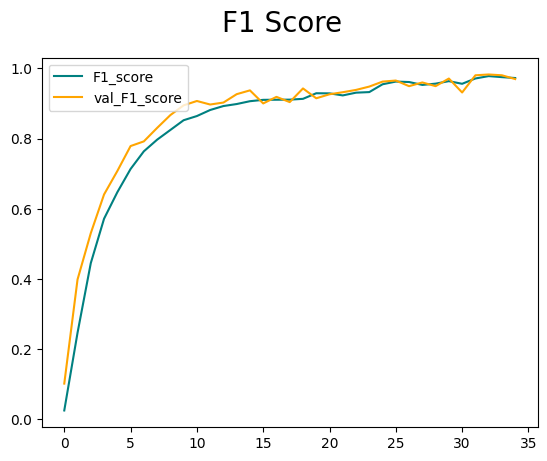

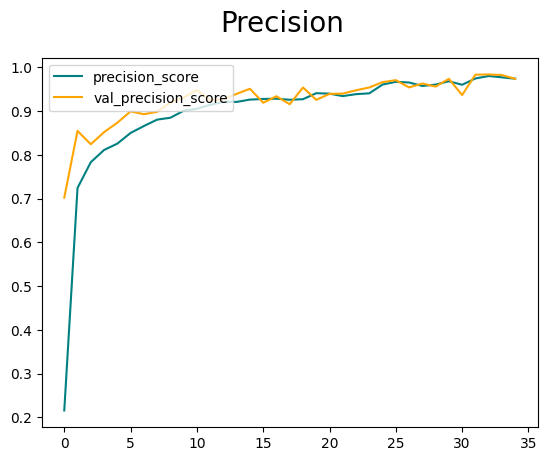

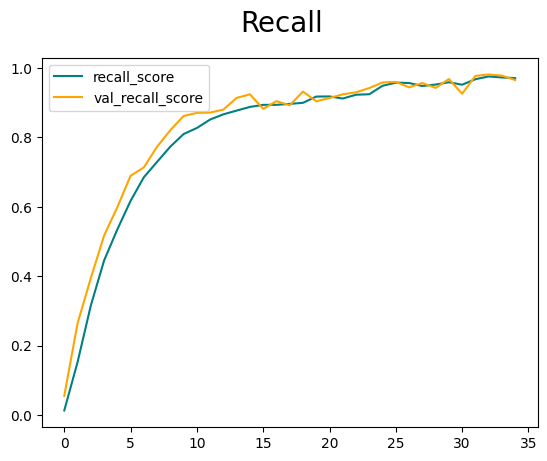

In [42]:
plot_history(hist=hist2c)

## Training Model 3

In [43]:
img_size3= (64, 64, 3)
batch_siz3 = 32
num_classes = 151

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

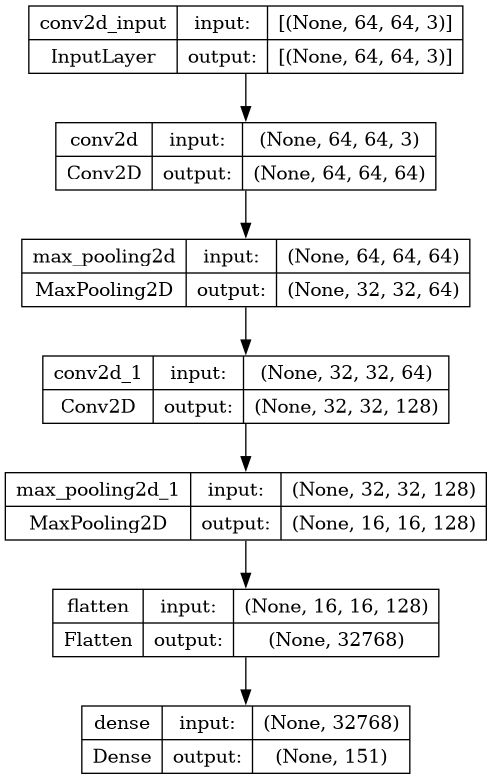

In [44]:
neuralnetwork_cnn3a = model_3a(img_size3, num_classes= 151)
neuralnetwork_cnn3a.summary()
# Visualizzazione modello Baseline
#tf.keras.utils.plot_model(neuralnetwork_cnn, show_shapes=True, rankdir= 'LR')
plot_model(neuralnetwork_cnn3a, to_file='model_plot4.png', show_shapes=True, show_layer_names=True)

In [45]:
neuralnetwork_cnn3b = model_3b(img_size3, num_classes= 151)
neuralnetwork_cnn3b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [46]:
neuralnetwork_cnn3c = model_3c(img_size3, num_classes= 151)
neuralnetwork_cnn3c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 151)               4

In [47]:
train_set3 , val_set3 = data_load(train_dir = train_dir,
                                  validation_dir = test_dir, 
                                  image_size=img_size3,
                                  num_batch= batch_siz3)

------ Loading TRAIN SET -------
Found 6995 images belonging to 151 classes.


------ Loading VALIDATION SET ------
Found 2404 images belonging to 151 classes.


In [48]:
hist3a , fil3a, es3a = train_model(model=neuralnetwork_cnn3a, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=31, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.9091 - acc: 0.1674 - f1_m: 0.0797 - precision_m: 0.3937 - recall_m: 0.0459
Epoch 1: loss improved from inf to 3.90907, saving model to model31.h5
219/219 [==============================] - 47s 206ms/step - loss: 3.9091 - acc: 0.1674 - f1_m: 0.0797 - precision_m: 0.3937 - recall_m: 0.0459 - val_loss: 2.9994 - val_acc: 0.3128 - val_f1_m: 0.2219 - val_precision_m: 0.7264 - val_recall_m: 0.1349 - lr: 0.0015
Epoch 2/35


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


219/219 [==============================] - ETA: 0s - loss: 2.6694 - acc: 0.3846 - f1_m: 0.3221 - precision_m: 0.7154 - recall_m: 0.2122
Epoch 2: loss improved from 3.90907 to 2.66937, saving model to model31.h5
219/219 [==============================] - 44s 201ms/step - loss: 2.6694 - acc: 0.3846 - f1_m: 0.3221 - precision_m: 0.7154 - recall_m: 0.2122 - val_loss: 2.0196 - val_acc: 0.5062 - val_f1_m: 0.4392 - val_precision_m: 0.7943 - val_recall_m: 0.3084 - lr: 0.0015
Epoch 3/35
219/219 [==============================] - ETA: 0s - loss: 2.1192 - acc: 0.5038 - f1_m: 0.4679 - precision_m: 0.7512 - recall_m: 0.3441
Epoch 3: loss improved from 2.66937 to 2.11920, saving model to model31.h5
219/219 [==============================] - 44s 202ms/step - loss: 2.1192 - acc: 0.5038 - f1_m: 0.4679 - precision_m: 0.7512 - recall_m: 0.3441 - val_loss: 1.9691 - val_acc: 0.5254 - val_f1_m: 0.5036 - val_precision_m: 0.7638 - val_recall_m: 0.3799 - lr: 0.0015
Epoch 4/35
219/219 [=========================

In [49]:
hist3b , fil3b, es3b = train_model(model=neuralnetwork_cnn3b, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=32, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.8822 - acc: 0.1761 - f1_m: 0.0743 - precision_m: 0.4003 - recall_m: 0.0422
Epoch 1: loss improved from inf to 3.88225, saving model to model32.h5
219/219 [==============================] - 47s 210ms/step - loss: 3.8822 - acc: 0.1761 - f1_m: 0.0743 - precision_m: 0.4003 - recall_m: 0.0422 - val_loss: 2.7282 - val_acc: 0.3773 - val_f1_m: 0.2446 - val_precision_m: 0.7810 - val_recall_m: 0.1484 - lr: 0.0015
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.6421 - acc: 0.3857 - f1_m: 0.3231 - precision_m: 0.7027 - recall_m: 0.2137
Epoch 2: loss improved from 3.88225 to 2.64207, saving model to model32.h5
219/219 [==============================] - 46s 208ms/step - loss: 2.6421 - acc: 0.3857 - f1_m: 0.3231 - precision_m: 0.7027 - recall_m: 0.2137 - val_loss: 2.3219 - val_acc: 0.4580 - val_f1_m: 0.4151 - val_precision_m: 0.7028 - val_recall_m: 0.2989 - lr: 0.0015
Epoch 3/35
219/219 [==================

In [50]:
hist3c , fil3c, es3c = train_model(model=neuralnetwork_cnn3c, 
                                train_set= train_set3, 
                                val_set= val_set3, 
                                early_stopping= True,
                                pat= 7, 
                                num_model=33, 
                                num_epochs= 35) # meglio che arrivi a 30

/tmp/ipykernel_27/3089735666.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/35
219/219 [==============================] - ETA: 0s - loss: 3.7197 - acc: 0.1987 - f1_m: 0.1006 - precision_m: 0.4396 - recall_m: 0.0588
Epoch 1: loss improved from inf to 3.71966, saving model to model33.h5
219/219 [==============================] - 48s 210ms/step - loss: 3.7197 - acc: 0.1987 - f1_m: 0.1006 - precision_m: 0.4396 - recall_m: 0.0588 - val_loss: 2.5116 - val_acc: 0.4472 - val_f1_m: 0.3151 - val_precision_m: 0.7963 - val_recall_m: 0.2007 - lr: 0.0015
Epoch 2/35
219/219 [==============================] - ETA: 0s - loss: 2.4793 - acc: 0.4330 - f1_m: 0.3656 - precision_m: 0.7484 - recall_m: 0.2461
Epoch 2: loss improved from 3.71966 to 2.47929, saving model to model33.h5
219/219 [==============================] - 45s 207ms/step - loss: 2.4793 - acc: 0.4330 - f1_m: 0.3656 - precision_m: 0.7484 - recall_m: 0.2461 - val_loss: 1.9045 - val_acc: 0.5420 - val_f1_m: 0.4714 - val_precision_m: 0.8336 - val_recall_m: 0.3314 - lr: 0.0015
Epoch 3/35
219/219 [==================

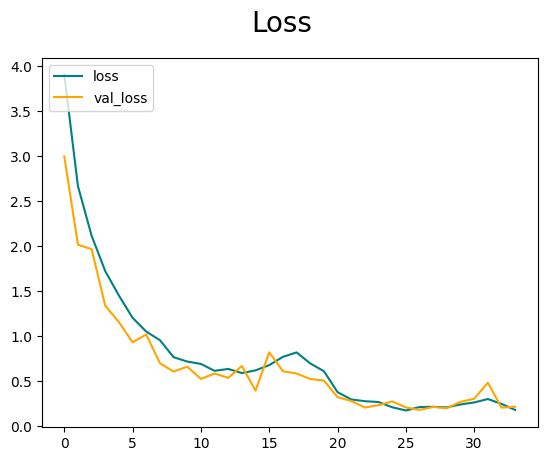

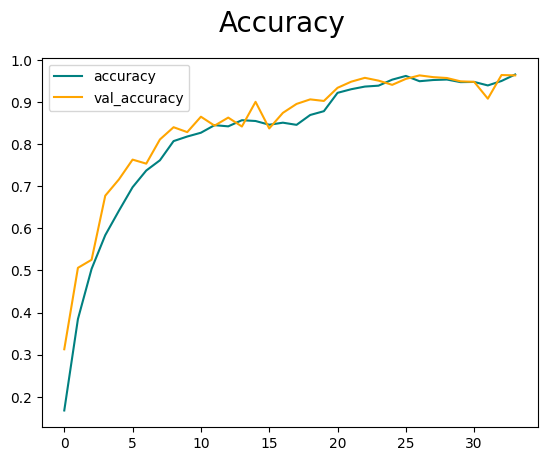

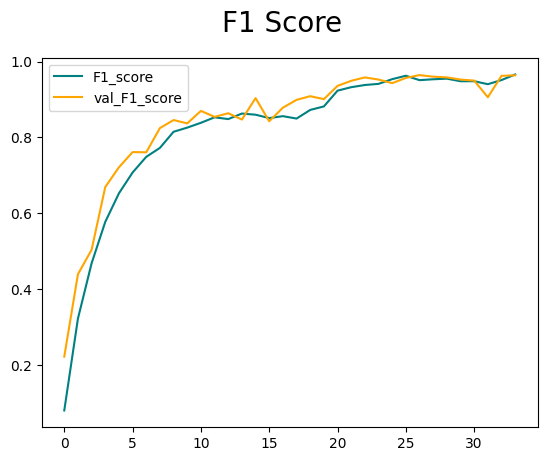

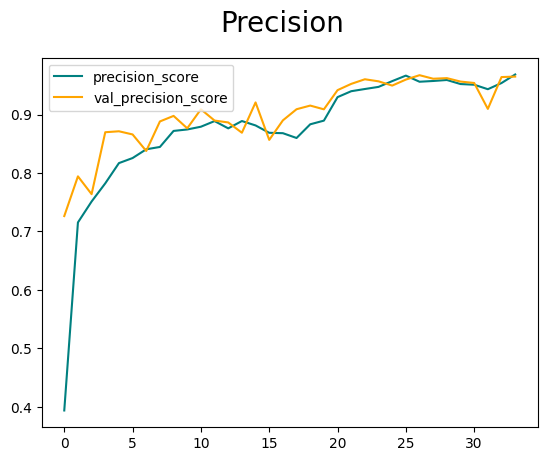

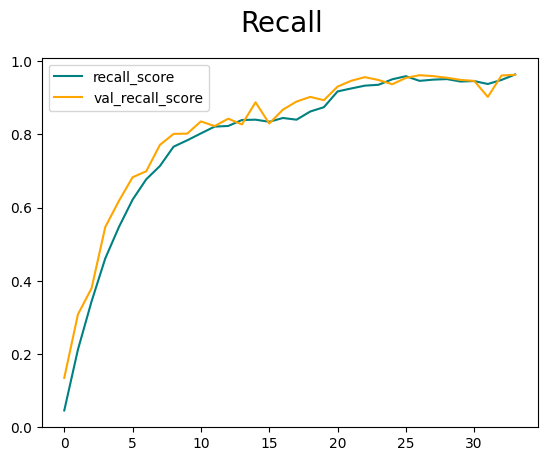

In [51]:
plot_history(hist=hist3a)

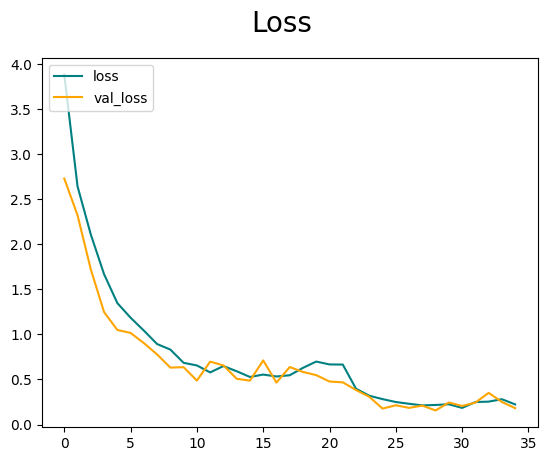

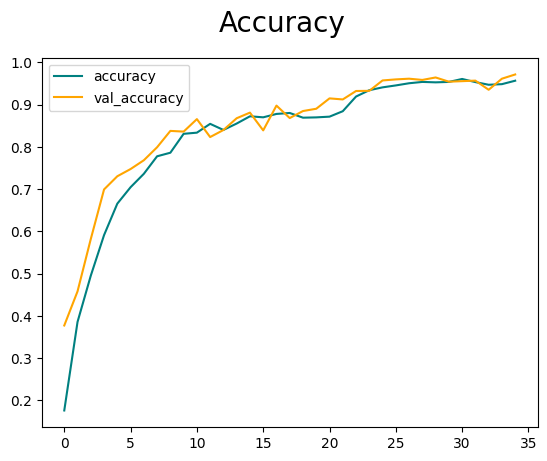

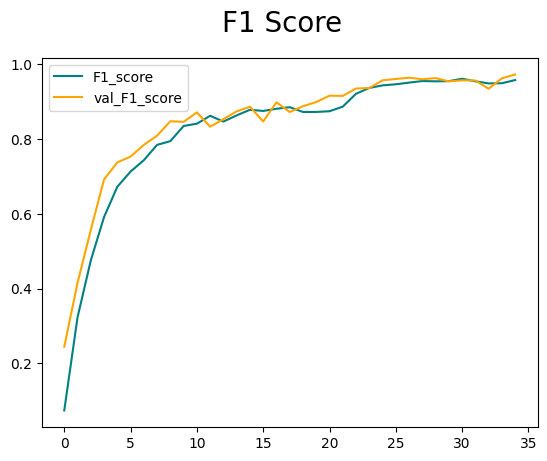

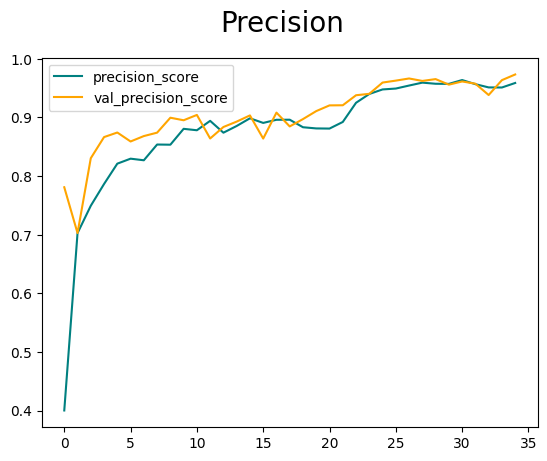

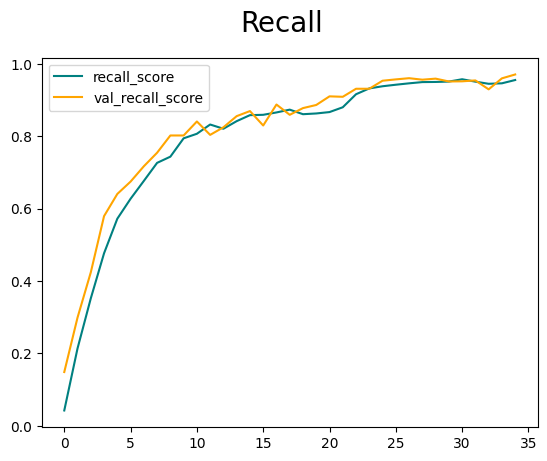

In [52]:
plot_history(hist=hist3b)

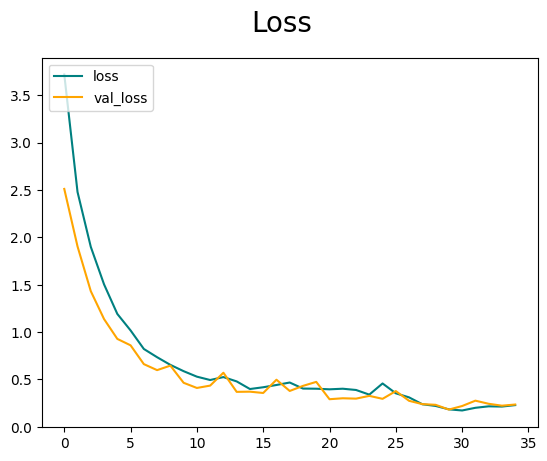

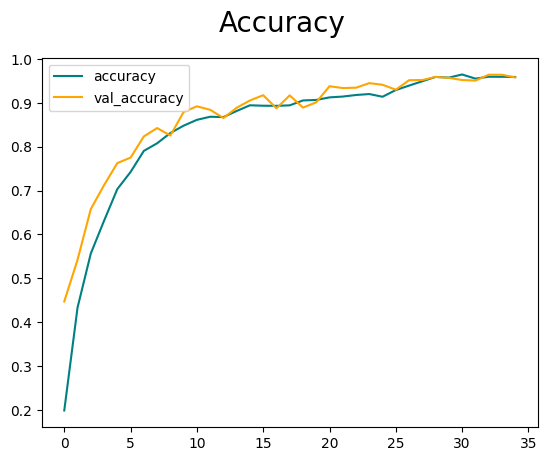

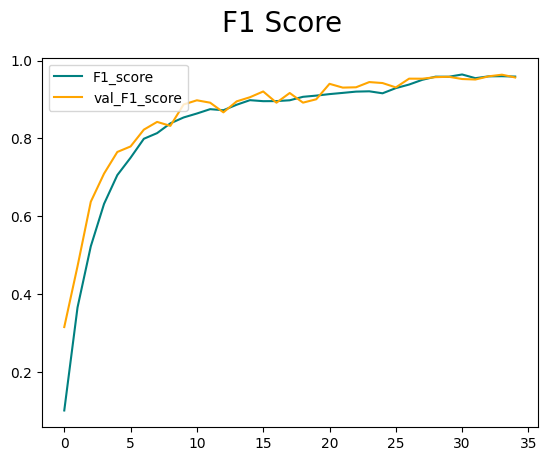

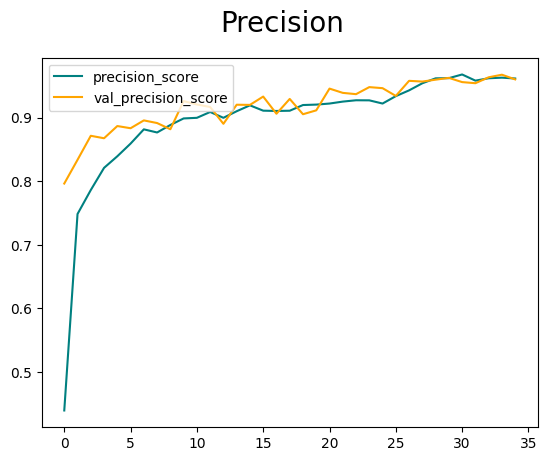

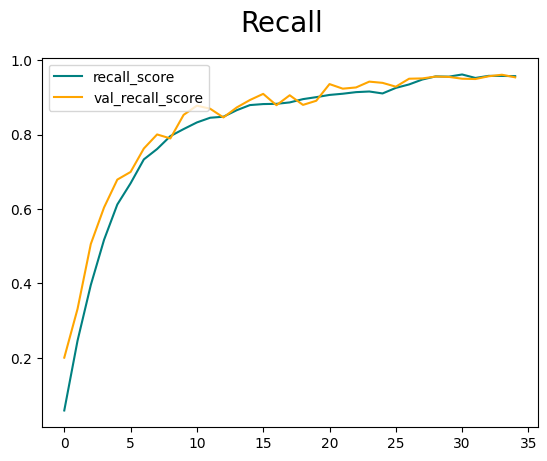

In [53]:
plot_history(hist=hist3c)